# Elaborato Data Intensive

Questo elaborato è basato su una competizione di kaggle [visualizzabile qui](https://www.kaggle.com/competitions/playground-series-s5e4/data?select=test.csv) \
Tutti i dataset sia train che test sono entrambi disponibili al link della competizione. 

## Istruzioni per il download del dataset
il Dataset va inserito all'interno della cartella /dataset. 
Il dataset è composto di 2 file test.csv e train.csv i rispettivi dataset di test e train.
Per procedere al download del dataset è necessario possedere un account Kaggle, generare un API key dalle impostazioni di kaggle e configurare il pacchetto python kaggle per il corretto funzionamento in locale.
Una volta configurato kaggle correttamente sarà sufficiente eseguire i seguente comandi all'interno della cartella `/dataset`: \
`kaggle competitions download -c playground-series-s5e4` e `unzip playground-series-s5e4.zip`

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [120]:
df_train = pd.read_csv("dataset/train.csv")
df_train = pd.read_csv("dataset/podcast_dataset.csv")
# df_train = df_train.drop(columns=["id"])
df_train["Ratio"] = df_train["Listening_Time_minutes"] / df_train["Episode_Length_minutes"].fillna(df_train["Listening_Time_minutes"])
df_train.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Ratio
0,Healthy Living,Episode 77,99.25,Health,21.37,Thursday,Night,70.22,3,Positive,55.158695,0.555755
1,Mystery Matters,Episode 6,19.43,True Crime,47.19,Friday,Evening,75.15,1,Neutral,7.686559,0.395603
2,Current Affairs,Episode 1,117.03,News,96.33,Sunday,Night,57.95,3,Neutral,110.064645,0.940482
3,Mystery Matters,Episode 38,16.97,True Crime,25.73,Monday,Night,24.19,0,Positive,12.000380,0.707153
4,Humor Hub,Episode 73,83.48,Comedy,76.69,Tuesday,Afternoon,42.31,3,Positive,NaN,NaN


In [13]:
numerical_cols = ['Episode_Length_minutes', 'Host_Popularity_percentage', 
                 'Guest_Popularity_percentage', 'Number_of_Ads']
categorical_cols = ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']


In [32]:
df_train["Number_of_Ads"].unique()
df_train[df_train["Number_of_Ads"] > 3] = 0

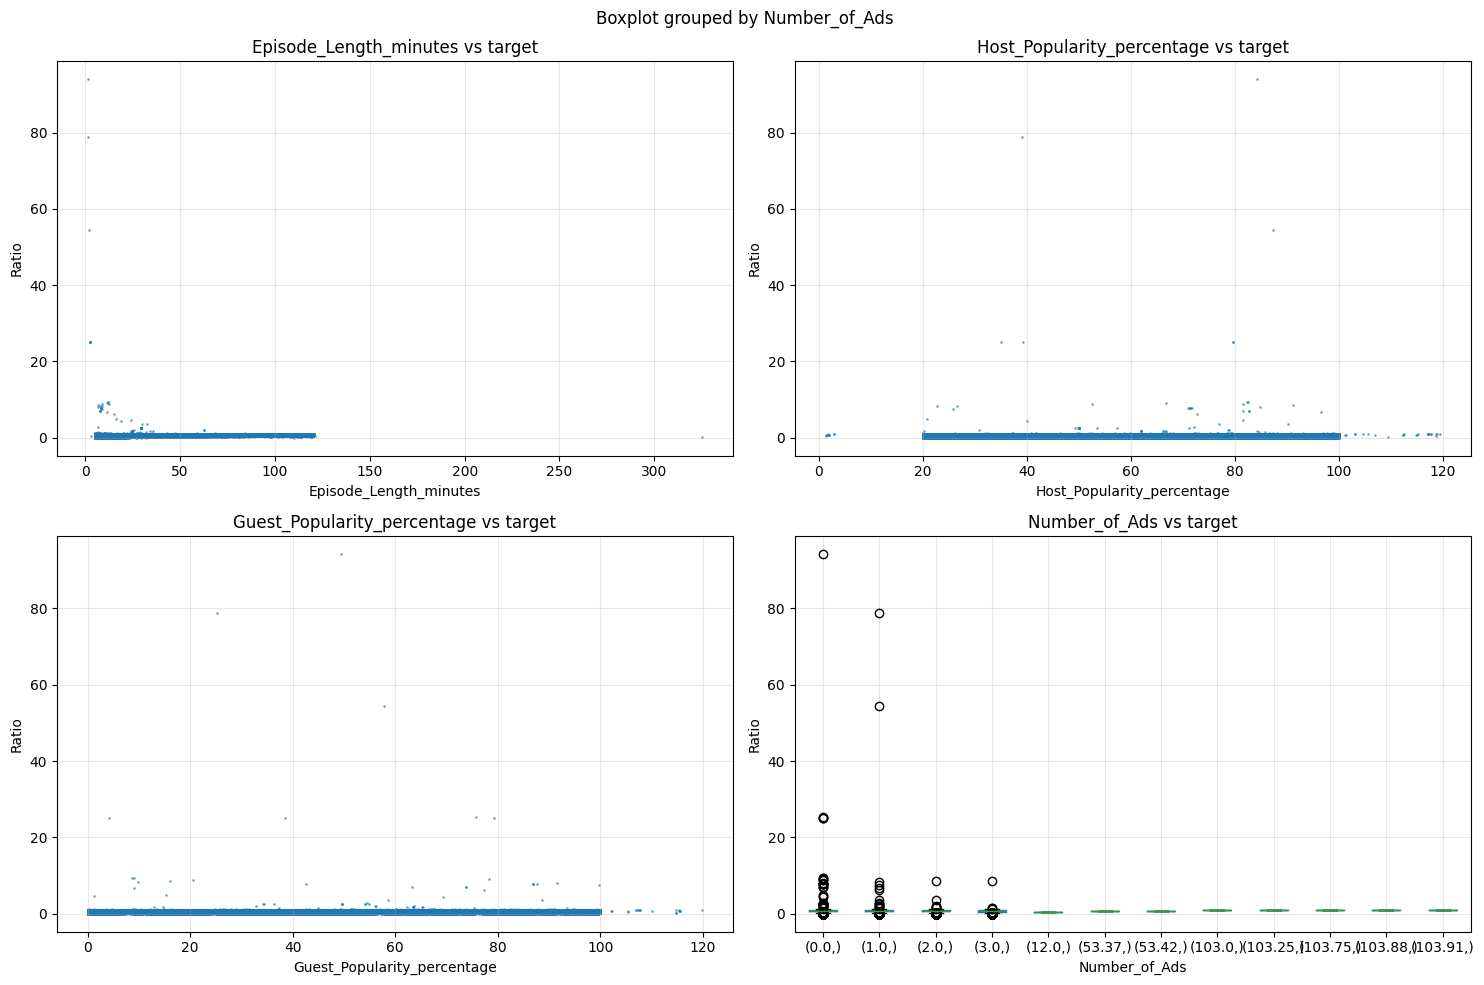

In [108]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()
target = "Ratio"

for i, col in enumerate(numerical_cols):
    if col in df_train.columns:
        if not col == "Number_of_Ads":
            axes[i].scatter(df_train[col], df_train[target], alpha=0.5, s=1)
            axes[i].set_xlabel(col)
            axes[i].set_ylabel(target)
            axes[i].set_title(f'{col} vs target')
            axes[i].grid(True, alpha=0.3)
        else:
            df_train.boxplot(column=target, by=[col], ax=axes[i])
            axes[i].set_xlabel(col)
            axes[i].set_ylabel(target)
            axes[i].set_title(f'{col} vs target')
            axes[i].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

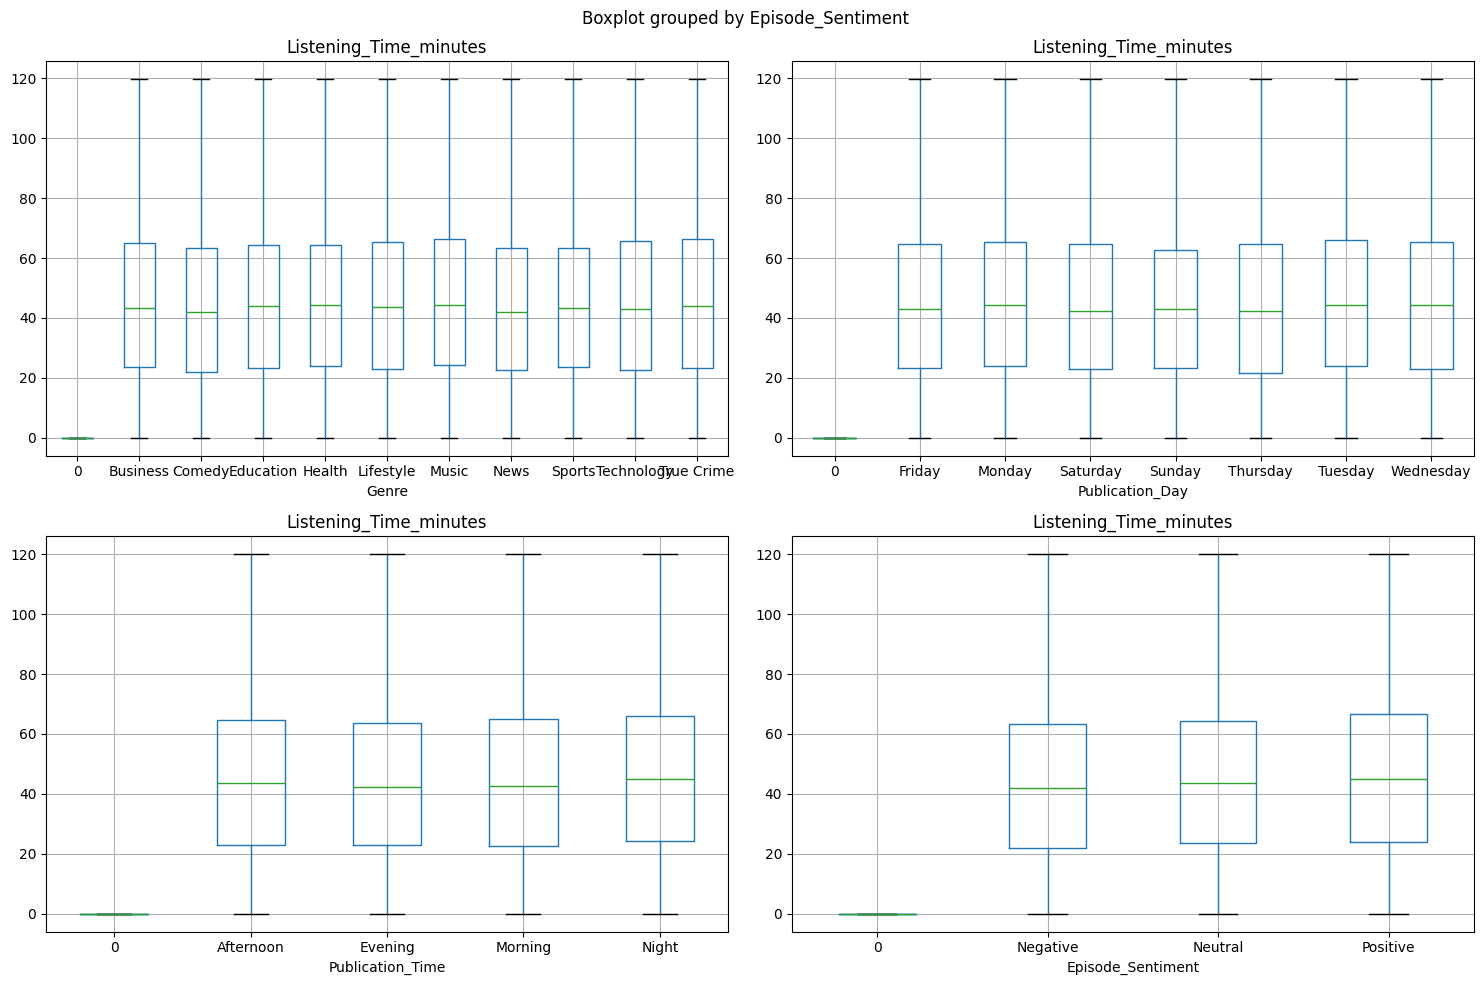

In [17]:
fig, axes = plt.subplots(2,2, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(categorical_cols):
    if col in df_train.columns:
        df_train.boxplot(column='Listening_Time_minutes', by=col, ax=axes[i])

plt.tight_layout()
plt.show()

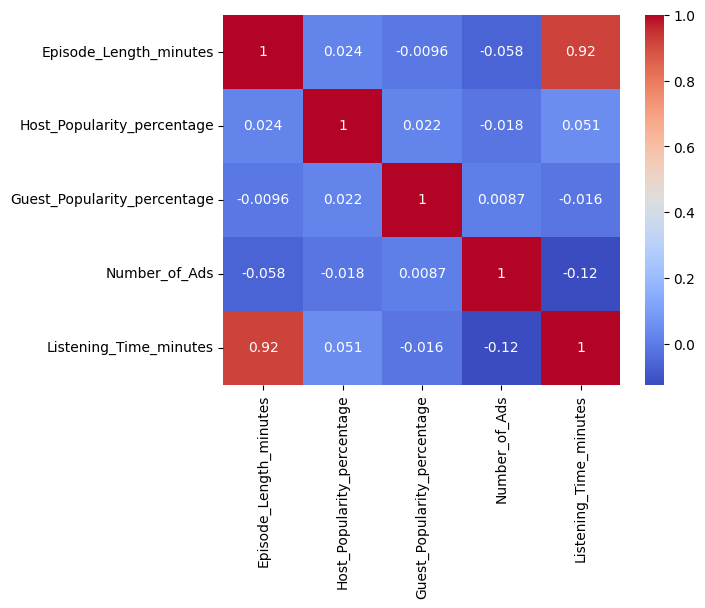

In [48]:
numeric_cols = numerical_cols + ["Listening_Time_minutes"]
corr = df_train[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

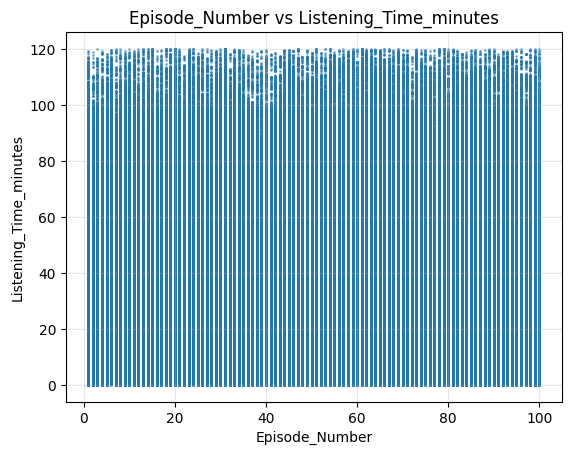

In [18]:
df_train['Episode_Number'] = df_train['Episode_Title'].str.extract(r'Episode (\d+)', expand=False)
df_train['Episode_Number'] = pd.to_numeric(df_train['Episode_Number'], errors='coerce')
df_train[['Episode_Title', 'Episode_Number']].head(10)
plt.scatter(df_train["Episode_Number"], df_train['Listening_Time_minutes'], alpha=0.5, s=1)
plt.xlabel("Episode_Number")
plt.ylabel('Listening_Time_minutes')
plt.title(f'{'Episode_Number'} vs Listening_Time_minutes')
plt.grid(True, alpha=0.3)

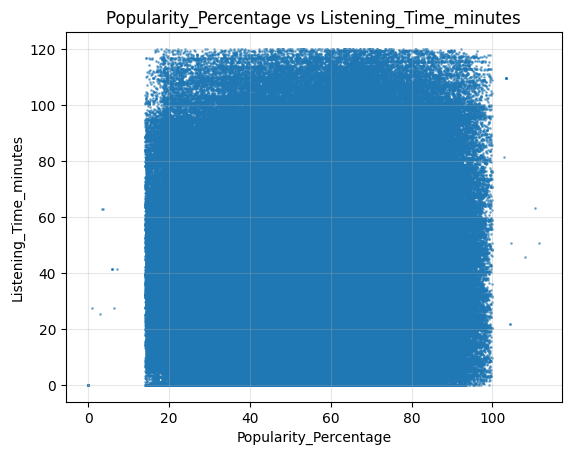

In [19]:
df_train["Popularity_Percentage"] = (df_train["Host_Popularity_percentage"].fillna(0) * 0.7) + (df_train["Guest_Popularity_percentage"].fillna(0) * 0.3)
df_train["Popularity_Percentage"]
plt.scatter(df_train["Popularity_Percentage"], df_train['Listening_Time_minutes'], alpha=0.5, s=1)
plt.xlabel("Popularity_Percentage")
plt.ylabel('Listening_Time_minutes')
plt.title(f'{'Popularity_Percentage'} vs Listening_Time_minutes')
plt.grid(True, alpha=0.3)

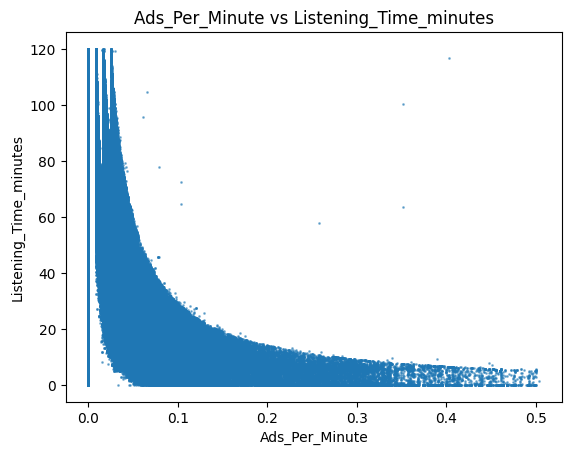

In [40]:
df_train['Ads_Per_Minute'] = df_train['Number_of_Ads'] / (df_train['Episode_Length_minutes'] + 1)
plt.scatter(df_train["Ads_Per_Minute"], df_train["Listening_Time_minutes"], alpha=0.5, s=1)
plt.xlabel("Ads_Per_Minute")
plt.ylabel('Listening_Time_minutes')
plt.title(f'{'Ads_Per_Minute'} vs Listening_Time_minutes')
plt.show()

<Axes: title={'center': 'Listening_Time_minutes'}, xlabel='Is_Weekend'>

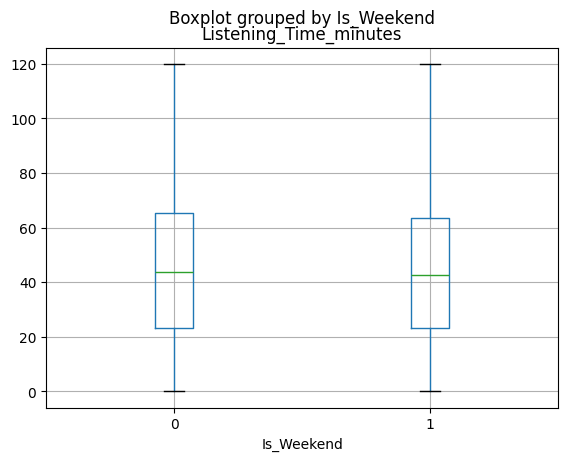

In [43]:
df_train['Is_Weekend'] = df_train['Publication_Day'].isin(['Saturday', 'Sunday']).astype(int)
df_train.boxplot(column='Listening_Time_minutes', by="Is_Weekend")

In [112]:
categorical_features = ['Podcast_Name', 'Genre']
numerical_features = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 
                     'Number_of_Ads', 'Episode_Number', 'Publication_Day_Numeric', 'Publication_Time_Numeric',
                     'Episode_Sentiment_Numeric', 'Ads_Per_Minute', 
                     'Is_Weekend', 'Guest_Host_Combined_Popularity']

def feature_engineering(df):
    df = df.copy()
    
    df['Episode_Number'] = df['Episode_Title'].str.extract(r'Episode (\d+)', expand=False).fillna(0)
    df['Episode_Number'] = pd.to_numeric(df['Episode_Number'], errors='coerce').fillna(0).astype(int)

    day_order = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 
                 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
    df['Publication_Day_Numeric'] = df['Publication_Day'].map(day_order).fillna(0)
    
    time_order = {'Morning': 1, 'Afternoon': 2, 'Evening': 3, 'Night': 4}
    df['Publication_Time_Numeric'] = df['Publication_Time'].map(time_order).fillna(0)
    
    sentiment_map = {'Negative': -1, 'Neutral': 0, 'Positive': 1}
    df['Episode_Sentiment_Numeric'] = df['Episode_Sentiment'].map(sentiment_map).fillna(0)
    
    df['Ads_Per_Minute'] = df['Number_of_Ads'] / (df['Episode_Length_minutes'] + 1)
    
    df['Is_Weekend'] = df['Publication_Day'].isin(['Saturday', 'Sunday']).astype(int)    

    df["Guest_Host_Combined_Popularity"] = df["Guest_Popularity_percentage"] * df["Host_Popularity_percentage"]
    
    return df

def fix_values(df):
    df = df.copy()

    def set_na_to_median(col_name):
        df[col_name] = df[col_name].fillna(df[col_name].median())

    set_na_to_median("Guest_Popularity_percentage")
    set_na_to_median("Episode_Length_minutes")
    set_na_to_median("Number_of_Ads")

    return df


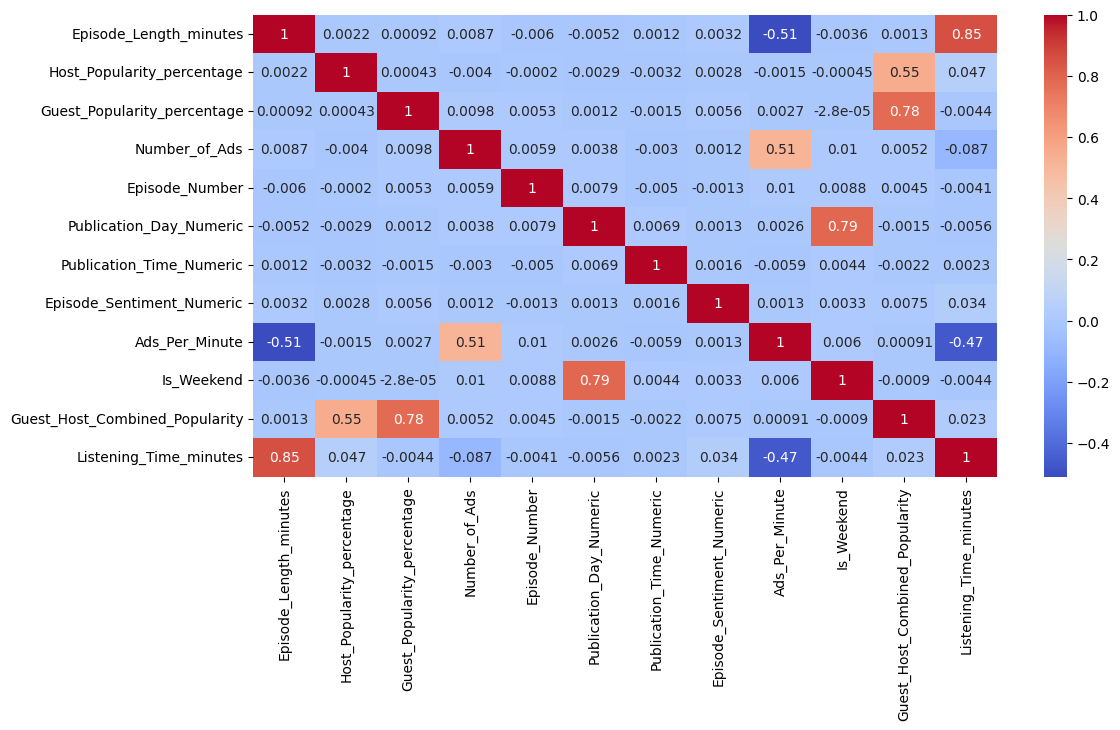

In [115]:
df_tmp = pd.read_csv("dataset/podcast_dataset.csv")
corr = feature_engineering(fix_values(df_tmp))[numerical_features + ["Listening_Time_minutes"]].corr()
plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

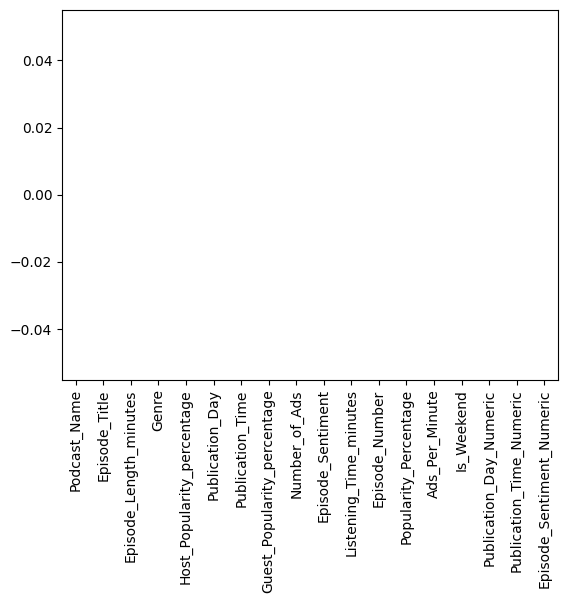

In [75]:
feature_engineering(fix_values(df_train)).isnull().sum().plot(kind='bar')
plt.show()

In [127]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb

# Load the dataset
df = pd.read_csv("dataset/podcast_dataset.csv")
df = df.dropna(subset=["Listening_Time_minutes"])

# Extract episode number from Episode_Title
df['Episode_Number'] = df['Episode_Title'].str.extract(r'Episode (\d+)', expand=False)
df['Episode_Number'] = pd.to_numeric(df['Episode_Number'], errors='coerce')

# Define features and target
target = 'Listening_Time_minutes'

df = feature_engineering(fix_values(df))

# Prepare the data
X = df[numerical_features + categorical_features]
y = df[target]

# Create preprocessing pipelines
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# Create the full pipeline
# pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('regressor', RandomForestRegressor(
#         n_estimators=100,
#         max_depth=20,
#         min_samples_split=5,
#         min_samples_leaf=2,
#         random_state=42,
#         n_jobs=-1
#     ))
# ])
# pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('regressor', xgb.XGBRegressor(
#         n_estimators=100,
#         reg_alpha=1,  # L1 penalty
#         reg_lambda=1  # L2 penalty
#     ))
# ])
# pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('regressor', xgb.XGBRegressor(
#     n_estimators=300,
#     learning_rate=0.05,
#     max_depth=6,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42
#     ))
# ])

In [128]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

print("Training the model:")
# Fit the pipeline
%time pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R2: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

Training the model:
CPU times: user 45.4 s, sys: 77.5 ms, total: 45.4 s
Wall time: 6.5 s
R2: 0.7583
RMSE: 13.4860


In [129]:
from sklearn.neural_network import MLPRegressor

print("Training the model:")
pipelineMLP = Pipeline([
    ('preprocessor', preprocessor),
    ('mlp', MLPRegressor(max_iter=2000, activation="relu", random_state=42))
])

grid = {
    "mlp__hidden_layer_sizes": [16, 32, (16, 8)],
    "mlp__batch_size": [100, 200]
}
skf = StratifiedKFold(3, shuffle=True)
gs = GridSearchCV(pipelineMLP, grid, cv=skf)

pipelineMLP.fit(X_train, y_train)

# Make predictions
y_pred = pipelineMLP.predict(X_test)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R2: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

Training the model:
R2: 0.7355
RMSE: 14.1081


In [5]:
my_df_test = pd.read_csv("dataset/test.csv")
my_df_test = feature_engineering(my_df_test)
X_fin = my_df_test[numerical_features + categorical_features]
X_fin = X_fin[mask]
y_pred = pipeline.predict(X_fin)
predictions_series = pd.Series(y_pred, index=my_df_test["id"], name='Listening_Time_minutes')
predictions_series.to_csv("dataset/pred.csv")

/tmp/ipykernel_7525/1768866896.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_fin = X_fin[mask]
